### Predicting which passengers survived the sinking of the [Titanic](https://en.wikipedia.org/wiki/RMS_Titanic)
* using a random forest this time

In [1]:
import csv as csv
import numpy as np
import pandas as pd

In [2]:
# We can use the pandas library in python to read in the csv file.
# This creates a pandas dataframe and assigns it to the titanic variable.
titanic = pd.read_csv("data/train.csv")

# Print the first 5 rows of the dataframe.
print(titanic.head(5))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex  Age  SibSp  \
0                            Braund, Mr. Owen Harris    male   22      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   38      1   
2                             Heikkinen, Miss. Laina  female   26      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   35      1   
4                           Allen, Mr. William Henry    male   35      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [3]:
print(titanic.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


* Since Age is missing some data, we'll have to clean it by inserting the median age

In [4]:
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())

### Non-numeric columns
* We have to either exclude our non-numeric columns when we train our algorithm (Name, Sex, Cabin, Embarked, and Ticket), or find a way to convert them to numeric columns.
* We'll ignore the Ticket, Cabin, and Name columns. There isn't much information we can extract from there. Most of the values in the cabin column are missing (only 204 values out of 891 rows), and it likely isn't a particularly informative column in the first place.
* The Ticket and Name columns are unlikely to tell us much without some domain knowledge about what the ticket numbers mean, and about which names correlate with characteristics like large or rich families.

### Converting the Sex column
* The Sex column is non-numeric, but we want to keep it around 
* first have to find all the unique genders in the column (we know male and female are there, but did whoever recorded the dataset use another code for missing values?)
* We'll also assign a code of 0 to male, and a code of 1 to female

In [5]:
# Find all the unique genders -- the column appears to contain only male and female.
print(titanic["Sex"].unique())

# Replace all the occurences of male with the number 0.
titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic["Sex"] == "female", "Sex"] = 1

['male' 'female']


## Converting the Embarked column

In [6]:
# Find all the unique values for "Embarked".
print(titanic["Embarked"].unique())

titanic["Embarked"] = titanic["Embarked"].fillna("S")
titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2

['S' 'C' 'Q' nan]


In [7]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.801346801347


### Parameter Tuning
* train more trees to increase accuracy
* tweak min_samples_split and min_samples_leaf to prevent overfitting

In [8]:
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.820426487093


### Generating new features
* The length of the name -- this could pertain to how rich the person was, and therefore their position in the Titanic.
* The total number of people in a family (SibSp + Parch).

In [9]:
# Generating a familysize column
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]

# The .apply method generates a new series
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

Extract the title using a regexp and map each unique title to an integer value

In [11]:
import re
import pandas

# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Get all the titles and print how often each one occurs.
titles = titanic["Name"].apply(get_title)
print(pandas.value_counts(titles))

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v

# Verify that we converted everything.
print(pandas.value_counts(titles))

# Add in the title column.
titanic["Title"] = titles

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
Name: Name, dtype: int64
1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
Name: Name, dtype: int64


### Family groups
We can also generate a feature indicating which family people are in. Because survival was likely highly dependent on your family and the people around you, this has a good chance at being a good feature.

To get this, we'll concatenate someone's last name with FamilySize to get a unique family id. We'll then be able to assign a code to each person based on their family id.

In [12]:
import operator

# A dictionary mapping family name to id
family_id_mapping = {}

# A function to get the id given a row
def get_family_id(row):
    # Find the last name by splitting on a comma
    last_name = row["Name"].split(",")[0]
    # Create the family id
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    # Look up the id in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            # Get the maximum id from the mapping and add one to it if we don't have an id
            current_id = (max(family_id_mapping.items(), key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]

# Get the family ids with the apply method
family_ids = titanic.apply(get_family_id, axis=1)

# There are a lot of family ids, so we'll compress all of the families under 3 members into one code.
family_ids[titanic["FamilySize"] < 3] = -1

# Print the count of each unique id.
print(pandas.value_counts(family_ids))

titanic["FamilyId"] = family_ids

-1      800
 14       8
 149      7
 63       6
 50       6
 59       6
 17       5
 384      4
 27       4
 25       4
 162      4
 8        4
 84       4
 340      4
 43       3
 269      3
 58       3
 633      2
 167      2
 280      2
 510      2
 90       2
 83       1
 625      1
 376      1
 449      1
 498      1
 588      1
dtype: int64


//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


<IPython.core.display.Javascript object>


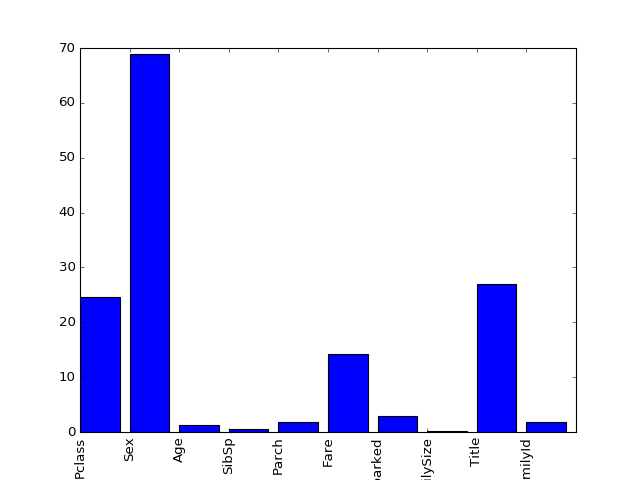

0.811447811448


In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_classif

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

%matplotlib notebook
# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

# Pick only the four best features.
predictors = ["Pclass", "Sex", "Fare", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold
import numpy as np

# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]],
    [RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1), ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]]
]

# Initialize the cross validation folds
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data.
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)

0.819304152637


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


## Run it over the test data

In [ ]:
import pandas
titanic_test = pandas.read_csv("data/test.csv")
titanic_test["Age"] = titanic_test["Age"].fillna(titanic["Age"].median())
titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic_test["Fare"].median())
titanic_test.loc[titanic_test["Sex"] == "male", "Sex"] = 0 
titanic_test.loc[titanic_test["Sex"] == "female", "Sex"] = 1
titanic_test["Embarked"] = titanic_test["Embarked"].fillna("S")

titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"] = 0
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"] = 2

# First, we'll add titles to the test set.
titles = titanic_test["Name"].apply(get_title)
# We're adding the Dona title to the mapping, because it's in the test set, but not the training set
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mapping.items():
    titles[titles == k] = v
titanic_test["Title"] = titles
# Check the counts of each unique title.
print(pandas.value_counts(titanic_test["Title"]))

# Now, we add the family size column.
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

# Now we can add family ids.
# We'll use the same ids that we did earlier.
print(family_id_mapping)

family_ids = titanic_test.apply(get_family_id, axis=1)
family_ids[titanic_test["FamilySize"] < 3] = -1
titanic_test["FamilyId"] = family_ids

titanic_test["NameLength"] = titanic_test["Name"].apply(lambda x: len(x))

In [ ]:
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4

In [ ]:
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4

predictions[predictions <= .5] = 0
predictions[predictions > .5] = 1
predictions = predictions.astype(int)
submission = pandas.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

In [ ]:
# make a kaggle submission from test set predictions with PassengerId,Survived
submission.to_csv("kaggle.csv", index=False)